### 1) Imports

In [61]:
#==========================================================
#                       Imports
#==========================================================
from __future__ import division

import os, sys, time
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv

import NAFFlib as pnf

# Added by Themis
import scipy
#sys.path.append('/Applications/anaconda/pkgs/')
#sys.path.append('/nfsbigdata1/tmastorigrp/src/')

from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss 
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeTable, WakeField

import PyHEADTAIL.multipoles.multipoles as multip

%matplotlib inline

In [62]:
import sys
sys.path.append('../../../../utils/')
from cmptTheoreticalEmitGrowth import *
from bunchLengthConversions import *
from coordinatesConversions import *
from cmpt_TuneSpreads import *

In [63]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 7,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [64]:
plt.close('all')

### 2) Variables we change

In [89]:
#==========================================================
#               Variables We Change
#==========================================================
n_turns = int(4e4)            #number of cycles to run the simulation for
decTurns = int(1)               #how often to record data

Q_y = 26.18                #How many times the particles oscillate in phase space each turn 
Q_x = 26.13                          # Will need it to be 16.25 IF CC feedback is used
                            # For this version of PyHEADTAIL Q_x should be an array

filename = 'file'      #Where the data for the run is saved

ampNoiseOn = 0              #Turns on the amplitude noise - 0 is off, 1 is on
phaseNoiseOn = 1           #Turns on the phase noise - 0 is off, 1 is on
stdAmpNoise = 1e-8          #Size of amplitude noise (1e-8 for ~22nm/s at 0 ampGain)
stdPhaseNoise = 1e-8      #Size of phase noise (1e-8 for ~24nm/s at 0 phaseGain)

Eb = 270e9
Vcc = 1e6
scale_factor = Eb/Vcc
stdPhaseNoise =  (1e-8*scale_factor)
print(stdPhaseNoise)

wakefieldOn = 0        # Turns on the wakefields

0.0027


### 3) Variables we don't change

In [90]:
#==========================================================
#           Variables We (Usually) Do Not Change
#==========================================================

gamma = 287.8
p0 = m_p*c*np.sqrt(gamma**2 - 1)
beta = np.sqrt(1 - 1/gamma**2)
circumference = 6911.5623
frev = 299792458/circumference


# PARAMETERS FOR TRANSVERSE MAP
# =====================
n_segments = 2
s = np.arange(0, n_segments+1)*circumference/n_segments
# optics at CC2
alpha_x = 0 * np.ones(n_segments)  # -0.9120242128
beta_x = 30.31164764 * np.ones(n_segments)
D_x = 0 * np.ones(n_segments) # -0.4954033073
alpha_y = 0 * np.ones(n_segments)  # 1.862209583
beta_y = 73.81671646 * np.ones(n_segments)
D_y = 0 * np.ones(n_segments)


i_wake = 1
# beta_x[i_wake] = 54.65 #### (for Q20)
# beta_y[i_wake] = 54.51 #### (for Q20)
beta_x[i_wake] = 42.0941 #### (for Q26)
beta_y[i_wake] = 42.0137 #### (for Q26)



Q_x, Q_y = 26.13, 26.18
Qp_x, Qp_y = 0, 0 #10

# detuning coefficients in (1/m)
app_x = 2000.0#5000.0  #2.4705e-15 #4e-11
app_xy = 0.0 #5000.0 #-0*2.25e-11
app_y = 2000.0 #1000.0  #-7.31-14 #0*3e-11

# PARAMETERS FOR LONGITUDINAL MAP
# =======================
alpha = 1.9e-3
Q_s = 0.0051
h1, h2 = 4620, 9240
V1, V2 = 5.008e6, 0e6
dphi1, dphi2 = 0, np.pi
p_increment = 0 * e/c * circumference/(beta*c)

# CREATE BEAM
# ===========
macroparticlenumber = int(1e4) # at least 5e5 particles are needed in the presence of the wakefields

charge = e
mass = m_p

R = circumference/(2*np.pi)
eta = alpha-1/gamma**2
beta_z = np.abs(eta)*R/Q_s


epsn_x = 2e-6
epsn_y = 2e-6     
#epsn_z    = 2.5
#sigma_z   = 0.155 #2*0.0755

tau = 1.7e-9 # 4 sigma_t [s]
sigma_z = c*tau/4 #0.155  # m
#sigma_z = %sigmaz #0.155
print(f'sigma_z= {sigma_z} [m]')


sigma_x = np.sqrt(epsn_x/(beta*gamma) * beta_x[0])
sigma_xp = sigma_x/beta_x[0]
sigma_y = np.sqrt(epsn_y/(beta*gamma) * beta_y[0])
sigma_yp = sigma_y/beta_y[0]
sigma_dp = sigma_z/beta_z
epsn_z = 4*np.pi * p0/e * sigma_z*sigma_dp

# generate bunches for the different intensities

intensity = 3.0e10
print(f'Createing bunch for intensity:{intensity}')

bunch = generate_Gaussian6DTwiss(macroparticlenumber, intensity, charge, mass, circumference, gamma, alpha_x[0], alpha_y[0], beta_x[0], beta_y[0], beta_z, epsn_x, epsn_y, epsn_z)

xoffset = 0.0*sigma_x #5e-4
yoffset = 0.0*sigma_y #0.5*sigma_y #5e-4
    
bunch.x += xoffset
bunch.y += yoffset
    
afile = open(f'bunch_intensity{intensity/1e10}1e10', 'wb')
pickle.dump(bunch, afile)
afile.close()



# SLICER FOR WAKEFIELDS
# ============
n_slices = 500 # 500
slicer_for_wakefields = UniformBinSlicer(n_slices, z_cuts=(-3.*sigma_z, 3.*sigma_z))#,circumference=circumference, h_bunch=h1)

# WAKEFIELD
# ==========
n_turns_wake = 1 # for the moment we consider that the wakefield decays after 1 turn
wakefile1=('../impedance_studies/SPS_complete_wake_model_2018_Q26.txt')


ww1 = WakeTable(wakefile1, ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y'], n_turns_wake=n_turns_wake)

# only dipolar kick
#my_length = len(ww1.wake_table['quadrupole_x'])
#ww1.wake_table['quadrupole_x'] = np.zeros(my_length)
#ww1.wake_table['quadrupole_y'] = np.zeros(my_length)



wake_field_kicker = WakeField(slicer_for_wakefields, ww1)#, beta_x=beta_x, beta_y=beta_y)



sigma_z= 0.12741179465 [m]
Createing bunch for intensity:30000000000.0
dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
quadrupole_x Assuming ultrarelativistic wake.
quadrupole_y Assuming ultrarelativistic wake.


### 4) Create transverse and longitudinal map

In [91]:
scale_factor = 2*bunch.p0  # scale the detuning coefficients in pyheadtail units
transverse_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y,
    [Chromaticity(Qp_x, Qp_y),
    AmplitudeDetuning(app_x*scale_factor, app_y*scale_factor, app_xy*scale_factor)])

longitudinal_map = LinearMap([alpha], circumference, Q_s)

### 5) Set up the acclerator

In [92]:
if ampNoiseOn == 1:
    ampKicks = np.random.normal(0, stdAmpNoise, n_turns)
else:
    ampKicks = np.zeros(n_turns)
if phaseNoiseOn == 1:
    phaseKicks = np.random.normal(0, stdPhaseNoise, n_turns)
else:
    phaseKicks = np.zeros(n_turns)

t0 = time.clock()

one_turn_map = []
for i, segment in enumerate(transverse_map):
    one_turn_map.append(segment)
    if wakefieldOn:
        if i+1 == i_wake:
            one_turn_map.append(wake_field_kicker)
            #one_turn_map.append(wake_field_wall)
one_turn_map.append(longitudinal_map)

n_damped_turns = int(n_turns/decTurns) # The total number of turns at which the data are damped.
                       # We want this number as an integer, so it can be used in the next functions. 


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


### 6) Start tracking

In [93]:
meanX, meanY = np.zeros(n_damped_turns), np.zeros(n_damped_turns)
emitX, emitY = np.zeros(n_damped_turns),  np.zeros(n_damped_turns)
    
# Iterate over the intensities, reload bunch object from file for each intensisty
#intensity_list = np.linspace(0, 5e10, 5)
print(f'Tracking for intensity:{intensity}')
    
file2 = open(f'bunch_intensity{intensity/1e10}1e10', 'rb')
bunch = pickle.load(file2)
file2.close()


Vcc = 1e6
#cc_voltage = lambda turn: np.interp(turn, [0, 200, 1e12], Vcc*np.array([0, 1, 1]))
#p_cc = Vcc / (gamma * .938e9)  # Vo/Eb
cc_voltage = lambda turn: np.interp(turn, [0, 200, 1e12], Vcc * np.array([0, 1, 1]))


for i in range(n_turns):

    # Gaussian Amplitude noise
    bunch.yp += ampKicks[i]*np.sin(2*np.pi*400e6/(bunch.beta*c)*bunch.z)

    # Gaussian Phase noise
    #bunch.yp += phaseKicks[i]*np.cos(2*np.pi*400e6/(bunch.beta*c)*bunch.z)
    deg2rad = np.pi/180
    psi = 20. #deg
    bunch.yp += np.cos(psi*deg2rad) * cc_voltage(i)*np.sin(2 * np.pi * 400e6 / (bunch.beta * c) * bunch.z + phaseKicks[i])/(gamma * .938e9)

    
    #These next two lines actually "run" the simulation - the computationally heavy part
    for m in one_turn_map:
        m.track(bunch)

        
    if i%decTurns is  0:
        j = int(i/decTurns)
        meanX[j] = np.mean(bunch.x)
        meanY[j] = np.mean(bunch.y)
        #meanXsq[j] = np.mean((bunch.x-np.mean(bunch.x))**2)
        #meanYsq[j] = np.mean((bunch.y-np.mean(bunch.y))**2)
        emitX[j] = bunch.epsn_x()
        emitY[j] = bunch.epsn_y()



dataExport = [meanX, meanY, emitX, emitY]

f = open(filename+f'_intensity{intensity/1e10:.2f}e10_ayy{app_y}_QpyQpx{Qp_x}.txt', 'w')

with f:
    out = csv.writer(f, delimiter=',')
    out.writerows(zip(*dataExport))

print('--> Done.')

print("Simulation time in seconds: " + str(time.clock() - t0))



Tracking for intensity:30000000000.0
--> Done.
Simulation time in seconds: 249.50048900000002


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [94]:
separationTime = 1 / frev * decTurns #There are decTurns revolutions before each recording of data
tspan = (np.arange(n_turns / decTurns) + 1.0) * separationTime #total time spanned by the simulation
# x - plane 
[m_x, b_x], cov_x = np.polyfit(tspan, emitX, 1, cov=True)
# compute the error of the gradient of the fit slope
err_x= np.sqrt(np.diag(cov_x))[0]
# y - plane
[m_y, b_y], cov_y = np.polyfit(tspan, emitY, 1, cov=True)
# compute the error of the gradient of the fit slope
err_y= np.sqrt(np.diag(cov_y))[0]

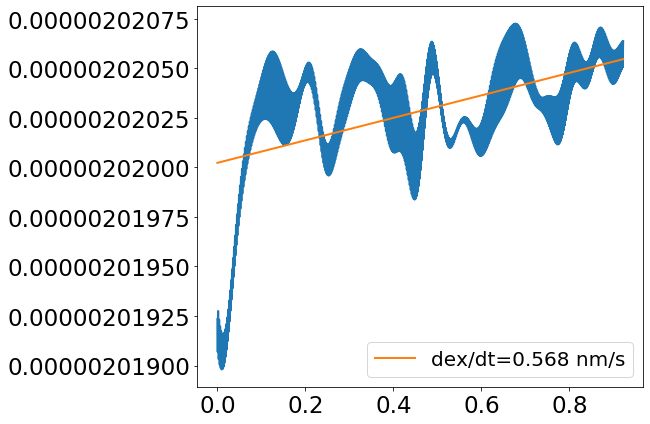

In [95]:
plt.plot(tspan, emitX)
plt.plot(tspan, b_x+tspan*m_x, label=f'dex/dt={m_x*1e9:.3f} nm/s')
plt.legend()

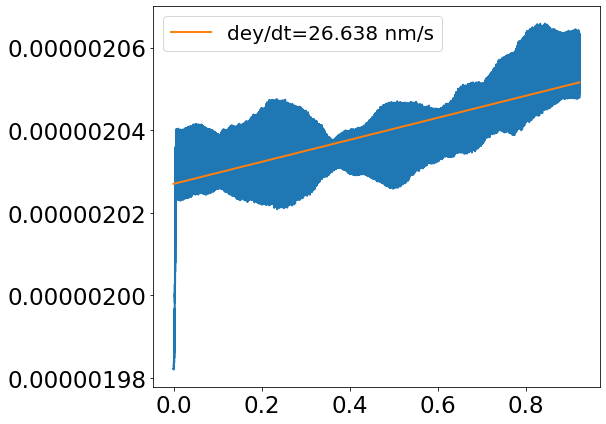

In [96]:
plt.plot(tspan, emitY)
plt.plot(tspan, b_y+tspan*m_y, label=f'dey/dt={m_y*1e9:.3f} nm/s')
plt.legend()

In [60]:
noise_type ='PN'
# Machine parameters
betay = 73.81671646 # 73 m at CC2, 76 m at CC1
Vcc = 1e6 # V
Eb = 270e9 # eV
gamma_0 = 287.8 
beta_0 = np.sqrt(1 - 1/gamma_0**2)
circumference = 6911.5623 # m
frev = 299792458/circumference # Hz


tau = 1.7e-9 # 4 sigma_t [s]
sigma_z = c*tau/4 #0.155  # m

f_CC = 400e6 # CC frequency in Hz
clight = 299792458 # m/s
# Noise kick parameters
A_phase = 1e-8 # rms kick in the simulation of the phase noise
A_amplitude = 0 # rms kick in the simulation of the amplitude noise
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
# Compute the PSD in rad^2/Hz and V^2/Hz
PSD_phi = (A_phase * scale_factor)**2/frev # rad^2/Hz
#PSD_phi = 1.42e-10
#PSD_phi = 1.4e-10
PSD_A = (A_amplitude * scale_factor)**2/frev # V^2/Hz
print(f'psd phi: {PSD_phi} rad^2/Hz, psd A: {PSD_A} V^2/Hz')

psd phi: 1.6806723392287607e-10 rad^2/Hz, psd A: 0.0 V^2/Hz


In [56]:
# Compute the correction factor due to the bunch length
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, f_CC)
CDeltaphi = cmpt_bunch_length_correction_factor(sigma_phi, 'PN')
CDeltaA = cmpt_bunch_length_correction_factor(sigma_phi, 'AN')
print('CDeltaPhi = {}, CDeltaA = {}'.format(CDeltaphi, CDeltaA))

if noise_type == 'PN':
    expected_growth = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
    my_color = 'C0'
    fill_bewtween_color = 'lightblue'
elif noise_type == 'AN':
    expected_growth = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
    my_color = 'C1'
    fill_bewtween_color = 'moccasin'
else:
    my_color = 'C2'
    expected_growth_1 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth_2 = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth = expected_growth_1 + expected_growth_2

print('expected growth = {} nm/s'.format(expected_growth*1e9))

CDeltaPhi = 0.5510474483948465, CDeltaA = 0.22447627580257676
expected growth = 25.389045082635636 nm/s
